In [1]:
from collections import OrderedDict
import gzip
import numpy as np
def load_sequences_from_bedfile(seqfile):
    seqs = []
    seqname_to_motifs = OrderedDict()
    fp = gzip.open(seqfile, "rb")
    print("#Loading " + seqfile + " ...")
    for line in fp:
        line=line.decode('utf8').split()
        seqs.append(line[1])
        if (len(line) > 2):
            seqname_to_motifs[line[0]] = line[2]
        else:
            seqname_to_motifs[line[0]] = ""
    fp.close()
    print("#Loaded " + str(len(seqs)) + " sequences from " + seqfile)
    return np.array(seqs), seqname_to_motifs

In [2]:
data_filename_positive = "/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/test_sim_positives.txt.gz"
data_filename_negative = "/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/test_sim_negatives.txt.gz"

pos_seqs, pos_seqname_to_motifs = load_sequences_from_bedfile(data_filename_positive)

neg_seqs, neg_seqname_to_motifs = load_sequences_from_bedfile(data_filename_negative)

seqs = np.concatenate((pos_seqs, neg_seqs), axis = 0)
labels = np.concatenate((np.full(pos_seqs.shape, 1), np.full(neg_seqs.shape, 0)), axis = 0)

#Loading /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/test_sim_positives.txt.gz ...
#Loaded 23827 sequences from /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/test_sim_positives.txt.gz
#Loading /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/test_sim_negatives.txt.gz ...
#Loaded 178032 sequences from /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/test_sim_negatives.txt.gz


In [3]:
real_data_filename_positive = "/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/real_data_test_pos.txt.gz"
real_data_filename_negative = "/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/real_data_test_neg.txt.gz"

real_pos_seqs, real_pos_seqname_to_motifs = load_sequences_from_bedfile(real_data_filename_positive)

real_neg_seqs, real_neg_seqname_to_motifs = load_sequences_from_bedfile(real_data_filename_negative)

real_seqs = np.concatenate((real_pos_seqs, real_neg_seqs), axis = 0)
real_labels = np.concatenate((np.full(real_pos_seqs.shape, 1), np.full(real_neg_seqs.shape, 0)), axis = 0)

#Loading /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/real_data_test_pos.txt.gz ...
#Loaded 23827 sequences from /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/real_data_test_pos.txt.gz
#Loading /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/real_data_test_neg.txt.gz ...
#Loaded 178032 sequences from /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/real_data_test_neg.txt.gz


In [4]:
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in seqs])
real_onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in real_seqs])

In [5]:
import keras
from keras.models import model_from_json
import tensorflow as tf

with tf.device('/gpu:1'):
    keras_model_weights = "/users/eprakash/git/interpret-benchmark/data/dnase_positives/momma_dragonn_config/deepsea_beluga/A549/sim_pos_and_neg/model_files/record_1_model_y86hu_modelWeights.h5"
    keras_model_json = "/users/eprakash/git/interpret-benchmark/data/dnase_positives/momma_dragonn_config/deepsea_beluga/A549/sim_pos_and_neg/model_files/record_1_model_y86hu_modelJson.json"

    keras_model = model_from_json(open(keras_model_json).read())
    keras_model.load_weights(keras_model_weights)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [6]:
preds = keras_model.predict(onehot_data)

In [7]:
real_preds = keras_model.predict(real_onehot_data)

In [8]:
preds=np.squeeze(preds)
real_preds=np.squeeze(real_preds)

In [9]:
seqs_to_index = {}
for i in range(len(seqs)):
    seqs_to_index.update({seqs[i]: i})

In [10]:
real_seqs_to_index = {}
for i in range(len(real_seqs)):
    real_seqs_to_index.update({real_seqs[i]: i})

In [11]:
sim_correct_real_wrong = []
for s in (range(len(real_seqs))):
    pred = int(preds[s] > 0.50)
    real_pred = int(real_preds[s] > 0.50)
    label = int(labels[s])
    if (pred == label and real_pred != label):
        sim_correct_real_wrong.append(s)

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
auroc = roc_auc_score(y_true=labels, y_score=preds)
auprc = average_precision_score(y_true=labels, y_score=preds)
print(auroc)
print(auprc)

0.8121846875427408
0.4749908947489309


In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
auroc = roc_auc_score(y_true=real_labels, y_score=real_preds)
auprc = average_precision_score(y_true=real_labels, y_score=real_preds)
print(auroc)
print(auprc)

0.8385991507691699
0.4660058060970453


Text(0, 0.5, 'Real Data')

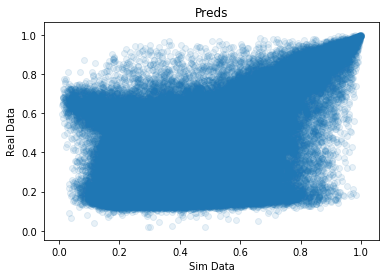

In [14]:
import matplotlib.pyplot as plt

plt.scatter(preds, real_preds, alpha=0.1)
plt.title("Preds")
plt.xlabel("Sim Data")
plt.ylabel("Real Data")